# Two Sigma News Exploratory Data Analysis
### By: Zihan

### Requirements

In order to run this file, you must have downloaded both datasets into the project root directory. Don't worry about accidentally uploading files to master because `.gitignore` is already handling that.

## Step 1: Data Curation

+ `wget kaggle_user_data_link` with a little bit of hacking (found the downloadable route in chrome browser)
+ the above won't work in usual way because of the network interruption issues (applicable only to large file)
+ uploaded data to dropbox to share with teammate
+ able to load data directly into working space (my playground)

In [18]:
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import datetime
import sys
from wordcloud import WordCloud

In [19]:
news_train_dir = "./new_train_df.csv"
news_train_df = pd.read_csv(news_train_dir)

market_train_dir = "./market_train_df.csv"
market_train_df = pd.read_csv(market_train_dir)

### 1. Get Relevant Columns Only for both Trade and New Data


In [562]:
import pandas as pd
import numpy as np
from datetime import datetime
import sys
from functools import reduce


# when debug mode is on, we only take a sub-sample of total data
debug_mode = True
# when we first load this in notebook, turn reload on. afterwards, turn it off no need to reload data everytime
reload = False

if reload:
    news_train_dir = "./new_train_df.csv"
    news_train_df = pd.read_csv(news_train_dir)

    market_train_dir = "./market_train_df.csv"
    market_train_df = pd.read_csv(market_train_dir)

# globals
news_col_extractor = ["time", "assetCodes", "headline", "urgency", "takeSequence", 
                    "subjects", "audiences", "relevance", 
                    'sentimentClass','sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
                    'noveltyCount12H', 'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 
                    'volumeCounts12H','volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D','volumeCounts7D'
                   ]

market_col_extractor = ["time", "assetCode", "volume", "close", "open", 
                        "returnsClosePrevRaw1", "returnsOpenPrevRaw1", "returnsClosePrevRaw10", "returnsOpenPrevRaw10",
                        "returnsOpenNextMktres10", "universe"]

identity = lambda series: reduce(lambda x, y: x, series)
coalesce = lambda x: list(x)

if debug_mode:
    news = news_df[60000:70000]
    market = market_df[:5000]
else:
    news = news_train_df
    market = market_train_df

assetCode_set = set(market_train_df["assetCode"].unique())

# extract relevant columns based on their descriptions
def extract_df(news_train_df, market_train_df):
    news_df = news_train_df[news_col_extractor]
    market_df = market_train_df[market_col_extractor]
    return news_df, market_df

# given a dataframe with field time convert into datetime, month and week
def extract_time_dependent_features(df, obj = None):
    # 1. get date
    df["datetime"] = df["time"].apply(lambda ts: ts[:10])
    # 2. get month
    if obj == "news":
        return df
    df["month"] = df["datetime"].apply(lambda ts: ts[5:7])
    # 3. get week
    df["week"] = df["datetime"].apply(lambda ts: datetime.strptime(ts, '%Y-%m-%d').strftime('%a'))
    return df

# apply helper aggregator to reduce assetCode in preparation for joining
def assetCodeMapper(assetCodeSet):
    assets = list(eval(assetCodeSet).intersection(assetCode_set))
    if assets == []:
        return None
    else:
        return assets[0]
    
# join if assetCode in assetCodes and time days are the same
def mergeDframes(news_df, market_df):
    anchor = ["datetime", "assetCode"]
    mergedDF = market_df.merge(news_df, on=["datetime", "assetCode"], how="left").dropna()
    return mergedDF

# squash columns so that (datetime, assetCodes) are unique
def squash(res):
    df = res.groupby("datetime")
    df = res.groupby(["datetime", "assetCode"]).agg({'volume': identity,
                                                    'open': identity,
                                                    'close': identity,
                                                    'returnsClosePrevRaw1': identity, 
                                                    'returnsOpenPrevRaw1': identity, 
                                                    'returnsClosePrevRaw10': identity,
                                                    'universe': identity,
                                                    'month': identity,
                                                    'week': identity,
                                                    'headline': coalesce,
                                                    'urgency': coalesce,
                                                    'takeSequence': coalesce,
                                                    'subjects': coalesce,
                                                    'audiences': coalesce,
                                                    'relevance': coalesce,
                                                    'sentimentClass': coalesce, 
                                                    'sentimentNegative': coalesce, 
                                                    'sentimentNeutral': coalesce,
                                                    'sentimentPositive': coalesce, 
                                                    'noveltyCount12H': coalesce, 
                                                    'noveltyCount24H': coalesce,
                                                    'noveltyCount3D': coalesce, 
                                                    'noveltyCount5D': coalesce, 
                                                    'noveltyCount7D': coalesce, 
                                                    'volumeCounts12H': coalesce,
                                                    'volumeCounts24H': coalesce, 
                                                    'volumeCounts3D': coalesce, 
                                                    'volumeCounts5D': coalesce, 
                                                    'volumeCounts7D': coalesce,
                                                    'returnsOpenNextMktres10': identity
                                                   })
    return df

# helper functiuons for urgency related partition calculation
def urgency_helper(x, column, urgency_type):
    relevance = [0 if i == urgency_type else i for i in x.relevance]
    return np.multiply(relevance, column).sum() / sum(relevance)

def urgency_dist_helper(x):
    d = Counter(x)
    if 1 not in d:
        d[1] = 0
    if 3 not in d:
        d[3] = 0
    return d[1], d[3]

def urgency_time_helper(x, column, urgency_type):
    # as indicator function
    relevance = [0 if i == urgency_type else 1 for i in x.relevance]
    return np.multiply(relevance, column).sum()

# generate relevance weighted features
def generate_relevance_weighted_sentiment(squashedDf):
    # we are removing urgency = 2 type because there are too few of them for learning
    squashedDf = squashedDf[squashedDf["urgency"] != 2]
    
    # for article and alert, let's compute different values
    urgency_ls = [1, 3]
    urgency_name = ["alert", "article"]
    time_ls = ["12H", "24H", "3D", "5D", "7D"]
    for i in range(len(urgency_ls)):
        name = urgency_name[i]
        u = urgency_ls[i]
        squashedDf[name+"_relevance_weighted_sentiment"] = squashedDf.apply(lambda x: urgency_helper(x, x.sentimentClass, u), axis=1)
        squashedDf[name+"_relevance_weighted_negative_sentiment"] = squashedDf.apply(lambda x: urgency_helper(x, x.sentimentNegative, u), axis=1)
        squashedDf[name+"_relevance_weighted_positive_sentiment"] = squashedDf.apply(lambda x: urgency_helper(x, x.sentimentPositive, u), axis=1)
        squashedDf[name+"_relevance_weighted_neutral_sentiment"] = squashedDf.apply(lambda x: urgency_helper(x, x.sentimentNeutral, u), axis=1)
        for time in time_ls:
            squashedDf[name+"_news_volume_sum_"+time] = squashedDf.apply(lambda x: urgency_time_helper(x, x["volumeCounts"+time], u), axis=1)
            squashedDf[name+"_news_novelty_sum_"+time] = squashedDf.apply(lambda x: urgency_time_helper(x, x["noveltyCount"+time], u), axis=1)
    squashedDf["relevance_weighted_sentiment"] = squashedDf.apply(lambda x: np.multiply(x.relevance, x.sentimentClass).sum() / sum(x.relevance), axis=1)
    squashedDf["relevance_weighted_negative_sentiment"] = squashedDf.apply(lambda x: np.multiply(x.relevance, x.sentimentNegative).sum() / sum(x.relevance), axis=1)
    squashedDf["relevance_weighted_positive_sentiment"] = squashedDf.apply(lambda x: np.multiply(x.relevance, x.sentimentPositive).sum() / sum(x.relevance), axis=1)
    squashedDf["relevance_weighted_neutral_sentiment"] = squashedDf.apply(lambda x: np.multiply(x.relevance, x.sentimentNeutral).sum(), axis=1)
    for time in time_ls:
        squashedDf["news_volume_sum_"+time] = squashedDf.apply(lambda x: sum(x["volumeCounts"+time]), axis=1)
        squashedDf["news_novelty_sum_"+time] = squashedDf.apply(lambda x: sum(x["noveltyCount"+time]), axis=1)
    squashedDf["alert"] = squashedDf.urgency.apply(lambda x: urgency_dist_helper(x)[0])
    squashedDf["article"] = squashedDf.urgency.apply(lambda x: urgency_dist_helper(x)[1])
    return squashedDf

def extract_features(df):
    extract_ls = ['month','week', 'alert', 'article',
              
                'alert_relevance_weighted_sentiment',
                'alert_relevance_weighted_negative_sentiment',
                'alert_relevance_weighted_positive_sentiment',
                'alert_relevance_weighted_neutral_sentiment',
                'alert_news_volume_sum_12H', 'alert_news_novelty_sum_12H',
                'alert_news_volume_sum_24H', 'alert_news_novelty_sum_24H',
                'alert_news_volume_sum_3D', 'alert_news_novelty_sum_3D',
                'alert_news_volume_sum_5D', 'alert_news_novelty_sum_5D',
                'alert_news_volume_sum_7D', 'alert_news_novelty_sum_7D',
              
                'article_relevance_weighted_sentiment',
                'article_relevance_weighted_negative_sentiment',
                'article_relevance_weighted_positive_sentiment',
                'article_relevance_weighted_neutral_sentiment',
                'article_news_volume_sum_12H', 'article_news_novelty_sum_12H',
                'article_news_volume_sum_24H', 'article_news_novelty_sum_24H',
                'article_news_volume_sum_3D', 'article_news_novelty_sum_3D',
                'article_news_volume_sum_5D', 'article_news_novelty_sum_5D',
                'article_news_volume_sum_7D', 'article_news_novelty_sum_7D',
              
                'relevance_weighted_sentiment', 'relevance_weighted_negative_sentiment',
                'relevance_weighted_positive_sentiment',
                'relevance_weighted_neutral_sentiment', 'news_volume_sum_12H',
                'news_novelty_sum_12H', 'news_volume_sum_24H', 'news_novelty_sum_24H',
                'news_volume_sum_3D', 'news_novelty_sum_3D', 'news_volume_sum_5D',
                'news_novelty_sum_5D', 'news_volume_sum_7D', 'news_novelty_sum_7D',
              
              'returnsOpenNextMktres10']
    df = df[df.universe == 1.0][extract_ls].dropna()
    return df
    
# orchestration
def main():
    news_df, market_df = extract_df(news, market)
    market_df = extract_time_dependent_features(market_df)
    news_df = extract_time_dependent_features(news_df, "news")
    news_df["assetCode"] = news_df["assetCodes"].apply(assetCodeMapper)
    mergedDF = mergeDframes(news_df, market_df)
    squashedDf = squash(mergedDF)
    featureDf = generate_relevance_weighted_sentiment(squashedDf)
    df = extract_features(featureDf)
    return df
    

# execution
df = main()

**assumption 1**: differernt types of urgency have different predicting power

if a particular asset on a given day does not have any news sentiments associated with it, we can rolling mean to potential override the gap. However, for a given day and a given asset, to compute that's day's asset sentiment, we should multiply it sentiment score with its relevance. A more relevant news should be weighted more. 

1. **simply joining by date**

```
res shape:  (13926784, 38)
(5000, 14)
(10000, 25)
```

2. **use aggregator to process assetCode**

77 percent have exact match
21 percent have 0 match
1.6 percent have 2 match

```python
assetCode_dist = news_dummy["assetCodes"].apply(assetCodeMapper)
print(7203022 / (7203022 + 1969618 + 156110))
print(1969618 / (7203022 + 1969618 + 156110))
print(156110/ (7203022 + 1969618 + 156110))

```

3. **joining by datetime and assetCode**

In [324]:
sum(res["headline"].isna())

3985

In [133]:
news_dummy = news_df[60000:70000]
market_dummy = market_df[:5000]
news_dummy = extract_time_dependent_features(news_dummy)
market_dummy = extract_time_dependent_features(market_dummy)

In [177]:
news_dummy["assetCode"] = news_dummy["assetCodes"].apply(assetCodeAggregator)

In [178]:
res = market_dummy.merge(news_dummy, on=["datetime", "assetCode"], how="left")

In [206]:
print("res shape: ", res.shape)
print(market_dummy.shape)
print(news_dummy.shape)

res shape:  (8895, 39)
(5000, 14)
(10000, 27)


In [207]:
res.columns

Index(['time_x', 'assetCode', 'volume', 'close', 'open',
       'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevRaw10',
       'returnsOpenPrevRaw10', 'returnsOpenNextMktres10', 'universe',
       'datetime', 'month_x', 'week_x', 'time_y', 'assetCodes', 'headline',
       'urgency', 'takeSequence', 'subjects', 'audiences', 'relevance',
       'sentimentClass', 'sentimentNegative', 'sentimentNeutral',
       'sentimentPositive', 'noveltyCount12H', 'noveltyCount24H',
       'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D',
       'month_y', 'week_y', 'assetSelectedCode'],
      dtype='object')

In [286]:
identity = lambda series: reduce(lambda x, y: x, series)
coalesce = lambda x: list(x)

In [293]:
from functools import reduce

x = res.groupby("datetime")
x.groups.keys()
x = res.groupby(["datetime", "assetCode"]).agg({'volume': identity,
                                                'open': identity,
                                                'close': identity,
                                                'returnsClosePrevRaw1': identity, 
                                                'returnsOpenPrevRaw1': identity, 
                                                'returnsClosePrevRaw10': identity,
                                                'universe': identity,
                                                'month_x': identity,
                                                'week_x': identity,
                                                'headline': coalesce,
                                                'urgency': coalesce,
                                                'takeSequence': coalesce,
                                                'subjects': coalesce,
                                                'audiences': coalesce,
                                                'relevance': coalesce,
                                                'sentimentClass': coalesce, 
                                                'sentimentNegative': coalesce, 
                                                'sentimentNeutral': coalesce,
                                                'sentimentPositive': coalesce, 
                                                'noveltyCount12H': coalesce, 
                                                'noveltyCount24H': coalesce,
                                                'noveltyCount3D': coalesce, 
                                                'noveltyCount5D': coalesce, 
                                                'noveltyCount7D': coalesce, 
                                                'volumeCounts12H': coalesce,
                                                'volumeCounts24H': coalesce, 
                                                'volumeCounts3D': coalesce, 
                                                'volumeCounts5D': coalesce, 
                                                'volumeCounts7D': coalesce,
                                                'returnsOpenNextMktres10': identity
                                               })

volume   open  close  returnsClosePrevRaw1  \
datetime   assetCode                                                   
2007-02-01 A.N         2606900.0  32.17  32.19              0.005938   
           AAI.N       2051600.0  11.08  11.12              0.004517   
           AAP.N       1164800.0  37.99  37.51             -0.011594   
           AAPL.O     23747329.0  86.23  84.74             -0.011548   
           ABB.N       1208600.0  18.01  18.02              0.011791   
           ABC.N       1657300.0  52.40  52.37             -0.000191   
           ABD.N       1186200.0  24.13  23.63             -0.020721   
           ABM.N        301200.0  25.90  26.19              0.013545   
           ABT.N       5692300.0  52.50  52.87             -0.002453   
           ABV.N        401800.0  52.10  52.46              0.014112   

                      returnsOpenPrevRaw1  returnsClosePrevRaw10  universe  \
datetime   assetCode                                                         
2007-02-01 A.N                   0.005312              -0.001860       1.0   
           AAI.N                -0.007168              -0.078708       0.0   
           AAP.N                 0.025648               0.014332       1.0   
           AAPL.O                0.016324              -0.048613       1.0   
           ABB.N                 0.025043               0.012929       1.0   
           ABC.N                 0.008468               0.089000       1.0   
           ABD.N                -0.007404               0.005104       0.0   
           ABM.N                 0.014890               0.068980       0.0   
           ABT.N                -0.004739               0.001515       1.0   
           ABV.N                 0.024784               0.042321       1.0   

                     month_x week_x  \
datetime   assetCode                  
2007-02-01 A.N            02    Thu   
           AAI.N          02    Thu   
           AAP.N          02    Thu   
           AAPL.O         02    Thu   
           ABB.N          02    Thu   
           ABC.N          02    Thu   
           ABD.N          02    Thu   
           ABM.N          02    Thu   
           ABT.N          02    Thu   
           ABV.N          02    Thu   

                                                               headline  \
datetime   assetCode                                                      
2007-02-01 A.N        [TRADE NEWS: Agilent Technologies Introduces P...   
           AAI.N      [AirTran Holdings, Inc., to Nominate Directors...   
           AAP.N                                                  [nan]   
           AAPL.O                                                 [nan]   
           ABB.N                                                  [nan]   
           ABC.N                                                  [nan]   
           ABD.N                                                  [nan]   
           ABM.N                                                  [nan]   
           ABT.N      [US Medicare proposes wider carotid stent cove...   
           ABV.N      [INBEV <INTB.BR> SAYS SHARE BUYBACK TO RUN UNT...   

                               ...            \
datetime   assetCode           ...             
2007-02-01 A.N                 ...             
           AAI.N               ...             
           AAP.N               ...             
           AAPL.O              ...             
           ABB.N               ...             
           ABC.N               ...             
           ABD.N               ...             
           ABM.N               ...             
           ABT.N               ...             
           ABV.N               ...             

                                                        noveltyCount24H  \
datetime   assetCode                                                      
2007-02-01 A.N                                               [0.0, 0.0]   
           AAI.N      [0.0, 1.0, 2.0, 1.0, 0.0, 2.0,

3985

In [323]:
res.shape

(8895, 39)

In [271]:
for i in range(1000):
    print(x["headline"][i])

['TRADE NEWS: Agilent Technologies Introduces Premier-Performance Network Analyzer... <A.N>', 'Life Scientists Embrace New Media <SIAL.O><A.N><ABI.N><AFFX.O><BDX.N><BEC.N><BIO.A><GE.N><IVGN.O><MIL.N><PKI.N><QGEN.O><TMO.N>']
['AirTran Holdings, Inc., to Nominate Directors for Midwest Air Group Board <MEH.A><AAI.N>', 'AIRTRAN HOLDINGS, INC., TO NOMINATE DIRECTORS FOR MIDWEST AIR GROUP BOARD', 'AIRTRAN HOLDINGS INC <AAI.N> SAYS PROPOSED SLATE OF NOMINEES FOR MIDWEST AIR GROUP <MEH.A> BOARD', 'AIRTRAN HOLDINGS INC <AAI.N> SAYS WOULD NOMINATE JEFFREY ERICKSON, CHARLES KALMBACH, JOHN ALBERTINE AT NEXT ANNUAL MEETING OF SHAREHOLDERS', 'AIRTRAN HOLDINGS INC <AAI.N> SAYS EXTENDING EXCHANGE OFFER UNTIL MARCH 8 2007 AT 12:01 MIDNIGHT ET FROM FEB 8 2007', 'AirTran extends Midwest offer, proposes directors', 'UPDATE 1-AirTran extends Midwest offer, proposes directors', "MIDWEST AIR GROUP COMMENTS ON AIRTRAN'S NOMINEES TO MIDWEST BOARD", "MIDWEST AIR GROUP INC <MEH.A> SAYS MOVE WOULD DENY MIDWEST'S 

In [284]:
res['audiences'].head(1000)

0                                         {'BSW', 'CNR'}
1                                                {'PRN'}
2                                                {'PRN'}
3                                             {'E', 'U'}
4                                             {'E', 'U'}
5                                             {'E', 'U'}
6                                             {'E', 'U'}
7          {'PCO', 'PCU', 'DNP', 'PSC', 'U', 'RNP', 'E'}
8          {'PCO', 'PCU', 'DNP', 'PSC', 'U', 'RNP', 'E'}
9                                             {'E', 'U'}
10                                            {'E', 'U'}
11                              {'DNP', 'E', 'RNP', 'U'}
12     {'PCO', 'ESN', 'PCU', 'DNP', 'PSC', 'U', 'RNP'...
13     {'PCO', 'T', 'ESN', 'PCU', 'DNP', 'PSC', 'U', ...
14                                                   NaN
15                                                   NaN
16                                                   NaN
17                             

In [ ]:
drop_columns = ["time_x", "]

In [11]:
Counter(news_train_df["audiences"])

Counter({"{'Z', 'O', 'OIL'}": 377,
         "{'PGE', 'PCO', 'G', 'ESN', 'MD', 'PCU', 'DNP', 'PSC', 'U', 'RNP', 'E'}": 11,
         "{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD', 'PMF', 'E', 'NAT'}": 26,
         "{'BSW', 'CNR'}": 560615,
         "{'UKI', 'G', 'ESN', 'GRO', 'ELN', 'EMK', 'T', 'SOF', 'MNI', 'NAW', 'NAT', 'D', 'M', 'MF', 'OIL', 'AUP', 'AUF', 'C', 'MTL', 'O', 'U', 'E'}": 43,
         "{'PCO', 'T', 'PCU', 'DNP', 'PSC', 'U', 'D', 'RNP', 'PTD', 'E'}": 1548,
         "{'Z', 'PCO', 'T', 'DNP', 'PSC', 'D', 'RNP', 'EMK', 'PTD', 'E'}": 113,
         "{'PRN'}": 163893,
         "{'PCO', 'PCU', 'MD', 'DNP', 'PSC', 'U', 'RNP', 'E'}": 479,
         "{'PCO', 'T', 'DNP', 'PSC', 'U', 'D', 'RNP', 'EMK', 'PTD', 'E'}": 319,
         "{'PGE', 'PCO', 'G', 'ESN', 'PCU', 'DNP', 'PSC', 'U', 'RNP', 'J', 'CAN', 'E'}": 150,
         "{'PGE', 'G', 'DNP', 'PSC', 'RNP', 'PMF', 'AUP', 'AUF'}": 2076,
         "{'UKI', 'PCO', 'ESN', 'DNP', 'PSC', 'AUP', 'RNP', 'EMK', 'AUF', 'E', 'SI'}": 1,
         "

In [10]:
Counter(news_train_df["headlineTag"])

Counter({nan: 6341993,
         'FEATURE': 4639,
         'PRESS DIGEST': 55344,
         'RPT': 143541,
         'TEXT': 43307,
         'UPDATE 1': 354579,
         'TABLE': 21285,
         'STOCKS NEWS EUROPE': 8324,
         'CORRECTED': 65367,
         'UPDATE 4': 43647,
         'EURO CORP': 932,
         'UPDATE 2': 197690,
         'REFILE': 32002,
         'NEWSMAKER': 1719,
         'UPDATE 3': 99093,
         'MOVES': 11613,
         'GLOBAL MARKETS': 3039,
         'UPDATE': 1162,
         'ADVISORY': 5926,
         'US RESEARCH NEWS': 16622,
         'Swiss stocks': 12128,
         'RESEARCH ALERT': 16168,
         'New Issue': 5009,
         'US STOCKS': 121731,
         'TAKE A LOOK': 29478,
         'HEADLINE STOCKS': 51365,
         'Before the Bell': 1465,
         'INSTANT VIEW 2': 1207,
         'INSTANT VIEW 3': 1185,
         'INSTANT VIEW 4': 814,
         'INSTANT VIEW 5': 500,
         'MMNEWS': 567,
         'STOCKS NEWS US': 36820,
         'ANALYSIS': 41933,

In [9]:
from collections import Counter
Counter(news_train_df["provider"])

Counter({'RTRS': 7287840,
         'BSW': 659798,
         'PRN': 687327,
         'RNS': 119591,
         'HSE': 302,
         'BSE': 8607,
         'MKW': 171630,
         'CNW': 46459,
         'HGN': 5607,
         'EQS': 5505,
         'ROM': 13435,
         'CSE': 110,
         'HIIS': 61921,
         'SEHK': 137,
         'CIS': 502,
         'PNW': 7416,
         'EANS': 349,
         'AWP': 1642,
         'SET': 2,
         'FSC': 717,
         'SSN': 53,
         'JCN': 1350,
         'GNW': 156367,
         'DGP': 234,
         'ACT': 323,
         'ACN': 1464,
         'TEN': 246,
         'ICE': 333,
         'ONE': 25233,
         'LSE': 64250})

In [14]:
len(news_train_df)

9328750

In [20]:
print(news_train_df.head(10)["headline"][9])

Tenet Completes Sale of Alvarado Hospital Medical Center <THC.N>


In [14]:
news_train_df.head(10)["relevance"]

0    0.235702
1    0.447214
2    0.377964
3    0.149071
4    0.149071
5    0.149071
6    0.149071
7    0.447214
8    0.149071
9    1.000000
Name: relevance, dtype: float64

In [15]:
news_train_df.head(10)["assetName"]

0                  PetroChina Co Ltd
1            Travelers Companies Inc
2                Wal-Mart Stores Inc
3                         Google Inc
4    XM Satellite Radio Holdings Inc
5                Sirius XM Radio Inc
6                     Walt Disney Co
7                     Microsoft Corp
8                         Yahoo! Inc
9              Tenet Healthcare Corp
Name: assetName, dtype: object

## Step 2: EDA

+ visualize random stock
+ outliers checking
+ visualize word cloud
+ looking at urgency

### 2.1 Visualize Random Stock's Closing Price

Randomly select 10 assets and plot the closing price for each.

In [7]:
data = []
for asset in np.random.choice(market_train_df['assetName'].unique(), 10):
    asset_df = market_train_df[(market_train_df['assetName'] == asset)]
    asset_df["time"] = pd.to_datetime(asset_df['time'], errors='coerce')
    data.append(go.Scatter(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset_df['close'].values,
        name = asset))
layout = go.Layout(dict(title = "10 Random Asset: Closing Price Time Series",
                  xaxis = dict(title = ''),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

### 2.1 Conclusion:

Be careful with survival bias here. 

+ Some stocks became into existence after the earlier datetime
+ some companies went bankrupt or got acquired in the middle

Therefore, we need to handle each stock's life span properly

### 2.2 Outliers

Garbage In, Garbage Out. Let's check if there are corrupted rows. 

In [9]:
market_train_df.head(10)

,Unnamed: 0,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,price_diff
0,0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0,0.02
1,1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0,0.04
2,2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0,-0.48
3,3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0,-1.49
4,4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0,0.01
5,5,2007-02-01 22:00:00+00:00,ABC.N,AmerisourceBergen Corp,1657300.0,52.37,52.40,-0.000191,0.008468,NaN,NaN,0.089000,0.077746,NaN,NaN,0.058680,1.0,-0.03
6,6,2007-02-01 22:00:00+00:00,ABD.N,ACCO Brands Corp,1186200.0,23.63,24.13,-0.020721,-0.007404,NaN,NaN,0.005104,0.026809,NaN,NaN,-0.044285,0.0,-0.50
7,7,2007-02-01 22:00:00+00:00,ABM.N,ABM Industries Inc,301200.0,26.19,25.90,0.013545,0.014890,NaN,NaN,0.068980,0.047311,NaN,NaN,0.016578,0.0,0.29
8,8,2007-02-01 22:00:00+00:00,ABT.N,Abbott Laboratories,5692300.0,52.87,52.50,-0.002453,-0.004739,NaN,NaN,0.001515,-0.004928,NaN,NaN,0.009861,1.0,0.37
9,9,2007-02-01 22:00:00+00:00,ABV.N,Companhia de Bebidas das Americas Ambev,401800.0,52.46,52.10,0.014112,0.024784,NaN,NaN,0.042321,0.027411,NaN,NaN,0.012917,1.0,0.36


In [8]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby('time').agg({'price_diff': ['std', 'min']}).reset_index()
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g

time  price_diff           
                                        std        min
736   2010-01-04 22:00:00+00:00  256.120931 -9948.9900
418   2008-09-29 22:00:00+00:00   81.761803 -3261.6136
338   2008-06-05 22:00:00+00:00   25.375271  -982.7000
317   2008-05-06 22:00:00+00:00   23.955264  -938.9500
165   2007-09-27 22:00:00+00:00   23.836764  -920.0000
2373  2016-07-06 22:00:00+00:00    6.402837   -49.3400
2043  2015-03-16 22:00:00+00:00    5.147030  -207.2100
34    2007-03-22 22:00:00+00:00    3.522257    -4.6100
91    2007-06-13 22:00:00+00:00    3.034322   -14.1700
5     2007-02-08 22:00:00+00:00    2.990822  -110.4800

Even Bitcin does not have a `9948` dollar drop in a day. Therefore, we know these data is corrupted. Let's check several manually.

In [9]:
market_train_df.sort_values('price_diff')[:10]

,Unnamed: 0,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,price_diff
1127598,1127598,2010-01-04 22:00:00+00:00,TW.N,Towers Watson & Co,223136.0,50.00,9998.9900,-0.058470,185.988360,-0.056911,163.671298,-0.024316,189.918708,0.034162,188.184866,13.167586,0.0,-9948.9900
627547,627547,2008-09-29 22:00:00+00:00,BK.N,Bank of New York Mellon Corp,18718479.0,26.50,3288.1136,-0.271578,99.125262,-0.064067,98.933405,-0.275164,84.405548,-0.189620,83.371024,4.061628,1.0,-3261.6136
502997,502997,2008-06-05 22:00:00+00:00,AHG.N,Apria Healthcare Group Inc,801892.0,17.29,999.9900,0.009930,58.523214,-0.001831,58.449248,0.104792,62.410907,0.140881,54.556118,-4.176442,0.0,-982.7000
471381,471381,2008-05-06 22:00:00+00:00,CEPH.O,Cephalon Inc,4846.0,61.04,999.9900,0.014628,15.547907,0.009554,14.982480,-0.039950,14.742916,-0.053743,14.824286,0.087719,1.0,-938.9500
242847,242847,2007-09-27 22:00:00+00:00,EXH.N,Archrock Inc,490100.0,79.99,999.9900,0.022236,11.658101,0.018789,11.570153,0.007304,11.618170,0.012866,552.522473,-0.550395,1.0,-920.0000
3264631,3264631,2015-03-16 22:00:00+00:00,TECD.O,Tech Data Corp,674385.0,56.59,263.8000,0.036447,3.868057,0.020318,3.781770,-0.066172,3.442573,-0.021922,3.284477,0.072616,0.0,-207.2100
7273,7273,2007-02-08 22:00:00+00:00,BA.N,Boeing Co,5155700.0,89.52,200.0000,-0.009186,1.207749,-0.006835,1.202170,0.043010,1.299798,NaN,NaN,0.004434,1.0,-110.4800
375899,375899,2008-02-06 22:00:00+00:00,CME.N,CME Group Inc,8676040.0,485.25,583.4900,-0.175866,-0.061536,-0.165490,-0.023137,-0.204495,0.025448,-0.188712,-0.021896,-0.006932,1.0,-98.2400
628075,628075,2008-09-29 22:00:00+00:00,IBM.N,International Business Machines Corp,9586679.0,114.46,191.9800,-0.041534,0.637915,0.018300,0.634691,-0.006337,0.664182,0.010630,0.666148,0.013094,1.0,-77.5200
3565205,3565205,2015-11-20 22:00:00+00:00,CMG.N,Chipotle Mexican Grill Inc,5023617.0,536.19,612.0000,-0.123171,0.027863,-0.123970,0.028139,-0.124445,0.004926,NaN,NaN,-0.001849,0.0,-75.8100


We know the data is not cleaned, so we need to clean it by std instead of pure price diff.

In [10]:
market_train_df['close_to_open'] =  np.abs(market_train_df['close'] / market_train_df['open'])

In [11]:
market_train_df['close_to_open'].head(3)

0    1.000622
1    1.003610
2    0.987365
Name: close_to_open, dtype: float64

In [12]:
def show_nlines_given_percent_change(pc = 0.8):
    close_open = market_train_df['close_to_open']
    print(f"In {( close_open >= 1+pc).sum()} lines price increased by {round(pc * 100,3)} percent or more.")
    print(f"In {( close_open <= 1-pc).sum()} lines price decreased by {round(pc * 100,3)} percent or more.")
    print("我是美丽的分割线--")

interested_stats = [0.1 * i for i in range(1, 10)]
for i in interested_stats:
    show_nlines_given_percent_change(i)

In 14447 lines price increased by 10.0 percent or more.
In 11795 lines price decreased by 10.0 percent or more.
我是美丽的分割线--
In 1211 lines price increased by 20.0 percent or more.
In 778 lines price decreased by 20.0 percent or more.
我是美丽的分割线--
In 278 lines price increased by 30.0 percent or more.
In 141 lines price decreased by 30.0 percent or more.
我是美丽的分割线--
In 127 lines price increased by 40.0 percent or more.
In 36 lines price decreased by 40.0 percent or more.
我是美丽的分割线--
In 83 lines price increased by 50.0 percent or more.
In 16 lines price decreased by 50.0 percent or more.
我是美丽的分割线--
In 69 lines price increased by 60.0 percent or more.
In 10 lines price decreased by 60.0 percent or more.
我是美丽的分割线--
In 60 lines price increased by 70.0 percent or more.
In 8 lines price decreased by 70.0 percent or more.
我是美丽的分割线--
In 45 lines price increased by 80.0 percent or more.
In 5 lines price decreased by 80.0 percent or more.
我是美丽的分割线--
In 39 lines price increased by 90.0 percent or more.
I

### 2.2 Summary

Several ways to remove outliers

+ we can create a script to check the open to close ratio for all the assets that had more than 20\% increase in a day
+ or we can manually set a cutoff or the open to close ratio and fill the open close price using their surrounding values

### 2.3 Visualize Words in News

Either we use topic modeling or word/sense embedding to construct this news sentiment modeling, so let's look at what kinds of words are out there.

In [13]:
np.random.choice(market_train_df['assetName'].unique(), 10)

array(['Human Genome Sciences Inc', 'SkillSoft Ltd',
       'Avery Dennison Corp', 'K-Sea Transportation Partners LP',
       'Sap France SA', 'Solaredge Technologies Inc',
       'Gilead Palo Alto Inc', 'Artisan Partners Asset Management Inc',
       'National Retail Properties Inc', 'Baldor Electric Co'],
      dtype=object)

To avoid, system executable path problem as noticed [here](https://github.com/jupyter/notebook/issues/2359), run the following bash script.

```!{sys.executable} -m pip install wordcloud```

In [25]:
text = ' '.join(np.random.choice(news_train_df['headline'].str.lower(), 10))
WordCloud(max_font_size=None, stopwords=None, background_color='white',
                          width=1200, height=1000).generate(text)

In [62]:
news_train_df.columns

Index(['Unnamed: 0', 'time', 'sourceTimestamp', 'firstCreated', 'sourceId',
       'headline', 'urgency', 'takeSequence', 'provider', 'subjects',
       'audiences', 'bodySize', 'companyCount', 'headlineTag',
       'marketCommentary', 'sentenceCount', 'wordCount', 'assetCodes',
       'assetName', 'firstMentionSentence', 'relevance', 'sentimentClass',
       'sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
       'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H',
       'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D',
       'volumeCounts7D'],
      dtype='object')

In [68]:
news_train_df["sourceId"].head(10)

0    e58c6279551b85cf
1    5a31c4327427f63f
2    1cefd27a40fabdfe
3    23768af19dc69992
4    23768af19dc69992
5    23768af19dc69992
6    23768af19dc69992
7    23768af19dc69992
8    23768af19dc69992
9    9fb959be43ed4ba2
Name: sourceId, dtype: object

In [66]:
news_train_df["sourceTimestamp"].head(10)

0    2007-01-01 04:29:32+00:00
1    2007-01-01 07:03:34+00:00
2    2007-01-01 11:29:56+00:00
3    2007-01-01 12:08:37+00:00
4    2007-01-01 12:08:37+00:00
5    2007-01-01 12:08:37+00:00
6    2007-01-01 12:08:37+00:00
7    2007-01-01 12:08:37+00:00
8    2007-01-01 12:08:37+00:00
9    2007-01-01 13:00:02+00:00
Name: sourceTimestamp, dtype: object

In [37]:
np.list(news_train_df['headline'].str.lower())

["china's daqing pumps 43.41 mln tonnes of oil in 06",
 'feature-in kidnapping, finesse works best',
 'press digest - wall street journal - jan 1',
 'press digest - new york times - jan 1',
 'press digest - new york times - jan 1',
 'press digest - new york times - jan 1',
 'press digest - new york times - jan 1',
 'press digest - new york times - jan 1',
 'press digest - new york times - jan 1',
 'tenet completes sale of alvarado hospital medical center <thc.n>',
 "rpt-wall st week ahead: mild jobs may lift stocks as '07 starts",
 "rpt-wall st week ahead: mild jobs may lift stocks as '07 starts",
 "rpt-wall st week ahead: mild jobs may lift stocks as '07 starts",
 'feature-in kidnapping, finesse works best',
 "rite aid can help you realize your new year's weight loss resolution <rad.n>",
 "commtouch reports: ''happy new year!'' virus ends 2006 with a blast <ctch.o>",
 'seoul antitrust body forms team on qualcomm-report',
 'seoul antitrust body forms team on qualcomm-report',
 'talks t

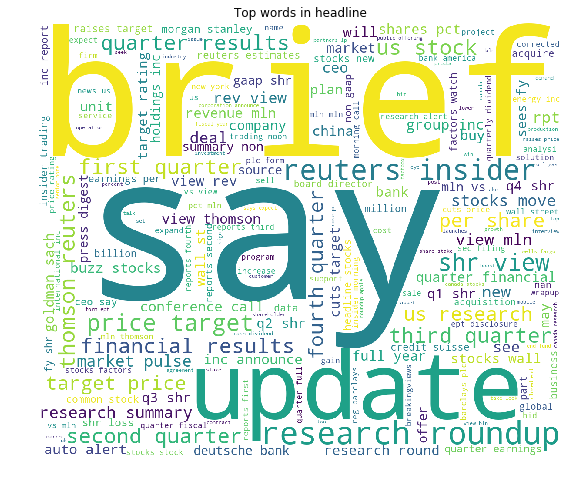

In [41]:
import matplotlib.pyplot as plt

def visualize_by_size(n = 100000):
    text = ' '.join(np.random.choice(list(news_train_df['headline'].str.lower()), n))
    wordcloud = WordCloud(max_font_size=None, stopwords=None, background_color='white',
                          width=1200, height=1000).generate(text)
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud)
    plt.title('Top words in headline')
    plt.axis("off")
    plt.show()
visualize_by_size()

### 2.4 Conclusion Urgency

Out of 10 million rows, there are only 25 rows that have category 25 in the `urgency` column. Such skewness might force us to abandoning rows with `urgency = 2`.

In [47]:
news_train_df['urgency'].value_counts()

3    6162567
1    3166158
2         25
Name: urgency, dtype: int64